cuda
Read in 5000 
700
200
100
Read in 5000 
700
200
100
Read in 5000 
700
200
100
Start/Continue training from epoch 150
Finish training for 20 epochs
Val Result:  {'loss': 1.1317349175612132, 'accuracy': tensor(56.2500, device='cuda:0')}
Test Result:  {'loss': 1.0954498300949733, 'accuracy': tensor(56.2500, device='cuda:0')}


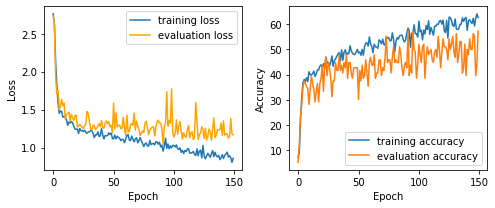

In [3]:
#!/usr/bin/env python

# python2 and python3 compatibility between loaded modules
from __future__ import print_function
import sys
sys.path.append("../")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from PIL import Image
from json import encoder
import pylab
import skimage.io as io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from torch.nn.utils.rnn import pack_padded_sequence
import torchvision as tv
import torch.utils.data as td
from torch.nn import functional as F
from torch import nn
import torch

import models.nntools_modified as nt
import utils.config as cfg
from utils.datareader_toy import toyScenesdata

# All imports here
# Reading files

# Vector manipulations

# DL framework
# torch

# import toy dataset class

# Plotting images
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# PIL Image

# regex for captions

# import nntools

# import add for fast addition between lists

# json for dumping stuff onto files as output
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


# NN Classifier from nntools

class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)


class CNNSceneContext(nn.Module):
    def __init__(self, scene_out, fine_tuning=True):
        super(CNNSceneContext, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # the average pooling is the same
        self.avgpool = vgg.avgpool
        # the classifier is also the same
        self.classifier = vgg.classifier
        # CODE to change the final classifier layer
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, scene_out)

    def forward(self, x):
        # COMPLETE the forward prop
        # x: torch.Size([16, 480, 640, 3])
        x = x.permute(0,3,1,2)
        x = x.float()
        f = self.features(x)
        f = self.avgpool(f)
        f = torch.flatten(f, 1)
        f = self.classifier(f)
        return f


class ResnetSceneContext(nn.Module):
    def __init__(self, scene_out, fine_tuning=True):
        super(ResnetSceneContext, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        
        # network definitions
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # layers
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # avgpool
        self.avgpool = resnet.avgpool
        # fc
        self.fc = resnet.fc

        # change output layer
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, scene_out)

    def forward(self, x):
        # forward prop through the network
        x = x.permute(0, 3, 1, 2)
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        f = self.layer1(x)
        f = self.layer2(f)
        f = self.layer3(f)
        f = self.layer4(f)
        a = self.avgpool(f)
        a = torch.flatten(a, 1)
        y = self.fc(a)
        return y

# class RNNAnchorProcess(nn.Module):
#     def __init__(self):
#         pass

#     def forward(self, x):
#         pass


# class RNNPastProcess(nn.Module):
#     def __init__(self):
#         pass

#     def forward(self):
#         pass


#     def greedy_sample(self):
#         """ Method to greedily sample from the RNN """
#         pass

class FCNPastProcess(nn.Module):
    def __init__(self, fcn_out):
        '''
        fcn_out: Num channels in the output (number of intents)
        '''
        super(FCNPastProcess, self).__init__()
        self.fc1 = nn.Linear(int(cfg.PAST_TRAJECTORY_LENGTH * 2), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, fcn_out)

    def forward(self, x):
        '''
        x dim: batch_size * (PAST_TRAJECTORY_LENGTH * 2)
        '''
        # assert (x.size() == torch.Size([2,PAST_TRAJECTORY_LENGTH])), print("Incorrect tensor shape passed to FCN")
#         print("In model: ", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.relu(x)


class IntentionEmbedding(nn.Module):
    def __init__(self, intent_in, intent_out):
        # intent_in: dim of past trajectory features
        super(IntentionEmbedding, self).__init__()
        self.emb = nn.Sequential(
            nn.Linear(4, 32)
        )
        self.encode = nn.Sequential(
            nn.Linear(32+intent_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, intent_out),
            nn.ReLU()
        )

    def forward(self, x, intention):
        # x: batch x n_vehicles x intent_in, past trajectory features
        # intention: batch x n_vehicles x 4, one-hot embedding of intentions
        intention = self.emb(intention)
        y = torch.cat((x, intention), dim=2)
        y = self.encode(y)
        return y


class ScoringFunction(nn.Module):
    def __init__(self, fdim):
        super(ScoringFunction, self).__init__()
        self.score = nn.Sequential(
            nn.Linear(fdim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # self.sm=nn.Softmax()

    def forward(self, x):
        # x: batch x fdim (scene+past_intent_embedding)
        y = self.score(x).squeeze()
        # y=self.sm(y)
        return y


class MultiAgentNetwork(NNClassifier):
    def __init__(self, fcn_out, n_intents, scene_out, intent_in, intent_out, score_in, fine_tuning=True):
        """
        n_intents - number of intents in dataset
        scene_out - dimension of the output for the scene parsing CNN
        intent_in - dimension of the input for the intention embedding
        intent_out - dimension of the output for the intention embedding
        score_in - dimension of the input of the scoring module
        """
        super(MultiAgentNetwork, self).__init__()
        if cfg.BACKBONE == "VGG":
            self.scene = CNNSceneContext(scene_out, fine_tuning)
        elif cfg.BACKBONE == "RESNET":
            self.scene = ResnetSceneContext(scene_out, fine_tuning)
        else:
            print("Incorrect BACKBONE specified in config.py")
            return(-1)
        self.past = FCNPastProcess(fcn_out); self.past.double()
        self.intent = IntentionEmbedding(intent_in, intent_out)
        self.score = ScoringFunction(scene_out+intent_out)
        self.n_intents = n_intents

    def forward(self, img, past_traj, gt_future):
        '''
        img: torch.Size([16, 480, 640, 3])
        past_traj: torch.Size([16, 2, 24])
        gt_future: torch.Size([16, 2])
        '''
        # past_traj: (n_batch, n_vehicles, ...)
        # gt_future: (n_batch, n_vehicles)
        # print("img shape: ", img.shape)
        # print("past traj shape: ", past_traj.shape)
        # print("gt_future shape: ", gt_future.shape)

        scene_output = self.scene(img) #TODO: Fix dimension mismatch
        # print("==================================")
        # print("Scene Output shape: ", scene_output.shape)

        n_batch = past_traj.shape[0]
        n_vehicles = past_traj.shape[1]
        n_modes = self.n_intents**n_vehicles
        scores = torch.zeros(n_batch, n_modes)

        fcn_out = torch.rand([n_batch, n_vehicles, cfg.FCN_OUT])
        for agent in range(n_vehicles):
            fcn_out[:,agent,:] = self.past(past_traj[:,agent,:int(cfg.PAST_TRAJECTORY_LENGTH*2)]) #torch.Size([16, 32])
        fcn_out = fcn_out.to(self.device)
        # print("==================================")
        gt_future = gt_future.long()
        gt_index = self.n_intents**torch.arange(n_vehicles)
        gt_index = gt_index.repeat(n_batch, 1)
        gt_index = gt_index.to(self.device)
        gt_index = torch.sum(gt_index*gt_future, dim=1, keepdim=True)
        
        scores = scores.to(self.device)
        for mode in range(n_modes):
            intentions = torch.zeros(n_batch, n_vehicles, self.n_intents) 
            for agent in range(n_vehicles):
                intention_index = int(mode/self.n_intents**(agent)) % self.n_intents
                intentions[..., agent, intention_index] = 1
            # past_output: (n_batch, n_vehicles, intent_in)

            # print("==================================")

            intentions = intentions.to(self.device)
            traj_output = self.intent(fcn_out, intentions) 
            # print(traj_output.shape)

            # traj_output: (n_batch, n_vehicles, intent_out)
            # or mean, or max
            # traj_output: (n_batch, intent_out)
            for agent in range(n_vehicles):
                combined_output = torch.cat((scene_output, traj_output[:,agent,:]), dim=1)
                # combined_output: (nbatch, scene_out+intent_out)
                scores[:, mode] = scores[:, mode]+self.score(combined_output)
        #scores = F.softmax(scores)
        
        return scores, gt_index.squeeze()


class ToyStatsManager(nt.StatsManager):
    def __init__(self):
        super(ToyStatsManager, self).__init__()

    def init(self):
        super(ToyStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        # TODO - modify the input params to accept the past trajectories also
        super(ToyStatsManager, self).accumulate(loss, x, y, d)

        # get the indices of the maximum activation of softmax for each sample
        _, l = torch.max(y, 1)

        # count the running average fraction of correctly classified samples
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        # this is the average loss when called
        loss = super(ToyStatsManager, self).summarize()

        # this is the average accuracy percentage when called
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}



# class to house training stuff
class TrainNetwork(object):
    def __init__(self):
        self._init_paths()

        self.training_dataset = toyScenesdata()
        # self.train_loader = td.Dataloader(self.training_dataset, **params)
        self.val_dataset = toyScenesdata(set_name="val")
        # self.val_loader = td.Dataloader(self.val_dataset, batch_size=cfg.BATCH_SIZE, pin_memory=True)
        self.test_dataset = toyScenesdata(set_name="test")
        self._init_train_stuff()

    def _init_paths(self):
        # data loading
        self.exp_name = cfg.EXP_NAME
        self.dataset_root_dir = cfg.DATA_PATH

        # output directory for training checkpoints
        # This changes for every experiment
        self.op_dir = cfg.OUTPUT_PATH + self.exp_name # + <experiment nunmber>

    def _init_train_stuff(self):
        self.lr = 1e-3
        # Change these values #DONE
        self.fcn_out = cfg.FCN_OUT
        self.n_intents = cfg.NUM_INTENTS
        self.scene_out = cfg.SCENE_OUT
        self.intent_in = cfg.INTENT_IN
        self.intent_out = cfg.INTENT_OUT
        self.score_in = cfg.SCORE_IN

        net = MultiAgentNetwork(self.fcn_out, self.n_intents, self.scene_out,
                                self.intent_in, self.intent_out, self.score_in)
        self.net = net.to(device)
        self.adam = torch.optim.Adam(net.parameters(), lr=self.lr)
        self.stats_manager = ToyStatsManager()
        self.exp = nt.Experiment(self.net, self.training_dataset, self.val_dataset, self.test_dataset, self.adam,
                                 self.stats_manager, output_dir=self.op_dir, perform_validation_during_training=True)

    def myimshow(self, img, ax=plt):
        image = image.to('cpu').numpy()
        image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
        image = (image + 1) / 2
        image[image < 0] = 0
        image[image > 1] = 1
        h = ax.imshow(image)
        ax.axis('off')
        return h

    def plot(self, exp, fig, axes):
        axes[0].clear()
        axes[1].clear()
        # Plot the training loss over the epochs
        axes[0].plot([exp.history[k][0]['loss']
                      for k in range(exp.epoch)], label="training loss")
        # Plot the evaluation loss over the epochs
        axes[0].plot([exp.history[k][1]['loss'] for k in range(
            exp.epoch)], color='orange', label="evaluation loss")
        # legend for the plot
        axes[0].legend()
        # xlabel and ylabel
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        # Plot the training accuracy over the epochs
        axes[1].plot([exp.history[k][0]['accuracy']
                      for k in range(exp.epoch)], label="training accuracy")
        # Plot the evaluation accuracy over the epochs
        axes[1].plot([exp.history[k][1]['accuracy']
                      for k in range(exp.epoch)], label="evaluation accuracy")
        # legend for the plot
        axes[1].legend()
        # xlabel and ylabel
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        plt.tight_layout()
        # set the title for the figure
        # fig.suptitle("Loss and Accuracy metrics")
        fig.canvas.draw()

    def run_plot_exp(self):
        fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
        self.exp.run(num_epochs=20, plot=lambda exp: self.plot(
            exp, fig=fig, axes=axes))

    def run_exp(self):
        # RUN on the server, without plotting
        self.exp.run(num_epochs=cfg.NUM_EPOCHS)

    def save_evaluation(self):
        exp_val = self.exp.evaluate()
        with open(self.op_dir+'val_result.txt', 'a') as t_file:
            print("Val Result: ", exp_val)
            t_file.write(str(exp_val))

    def save_testing(self):
        exp_test = self.exp.test()
        with open(self.op_dir+'test_result.txt', 'a') as t_file:
            print("Test Result: ", exp_test)
            t_file.write(str(exp_test))

def main():
    tn = TrainNetwork()
    tn.run_plot_exp()
    tn.save_evaluation()
    tn.save_testing()


if __name__ == '__main__':
    main()


In [2]:
%matplotlib inline